# 외국어 문장 판별하기
알파벳을 사용하는 언어는 프랑스어, 타갈로그어, 인도네시아어 등과 같이 많다 -> 알파벳을 사용한다고 해서 영어 X

## 알파벳을 사용하는 자연 언어가 어떤 나라의 말인지 판정하는 프로그램

### 판정 방법
* 글자를 곧바로 학습기에 넣을 수 없기에 글자 데이터를 나타내는 벡터로 변경해서 사용!!
* 그럼 어떻게?? : 언어가 다르면 알파벳의 출현 빈도가 다르다는 점을 활용(언어마다 자주 사용하는 표현과 단어가 다르기 때문에 출현 빈도가 달라진다.)
* => 'a'부터 'z'까지의 출현 빈도를 확인하고 이를 특징으로 사용

## 언어 판별 프로그램

In [6]:
from sklearn import svm, metrics
import glob, os.path, re, json

# 텍스트를 읽어 들이고 출현 빈도 조사하기
def check_freq(filename):
    name = os.path.basename(filename)
    lang = re.match(r'^[a-z]{2,}', name).group() # Q) 정규표현식 이해x: ^이게 영어 소문자 2번이상 반복 아닌 것들 아닌가??
    with open(filename, "r", encoding = "utf-8") as f:
        text = f.read()
    text = text.lower() # 소문자로 변환
    # 숫자 세기 변수(cnt) 초기화
    cnt = [0 for n in range(0, 26)]
    code_a = ord("a") # ord(): 문자의 유니코드 값을 돌려주는 함수 ord('a')=97 / ord('가')=44032
    code_z = ord("z")
    # 알파벳 출현 횟수 구하기
    for ch in text:
        n = ord(ch)
        if code_a <= n <= code_z: # a~z 사이에 있을 때
            cnt[n - code_a] += 1
    # 정규화하기
    total = sum(cnt)
    # 출현 횟수를 출현 빈도로 변환 -> 각 텍스트 파일에 있는 문자 수가 다르므로 출현 회수를 비교하면 동일한 규칙이 적용되지 X
    freq = list(map(lambda n: n / total, cnt))
    return (freq, lang)

# 각 파일 처리하기
def load_files(path):
    freqs = []
    labels = []
    file_list = glob.glob(path)
    for filename in file_list:
        r = check_freq(filename)
        freqs.append(r[0])
        labels.append(r[1])
    return {"freqs": freqs, "labels": labels}

data = load_files("./lang/train/*.txt")
test = load_files("./lang/test/*.txt")

# 이후를 대비해서 JSON으로 결과 저장하기
with open("./lang/freq.json", "w", encoding="utf-8") as fp:
    json.dump([data, test], fp)

# 학습하기
clf = svm.SVC()
clf.fit(data["freqs"], data["labels"])

# 예측하기
predict = clf.predict(test["freqs"])

# 결과 테스트하기
ac_score = metrics.accuracy_score(test["labels"], predict)
cl_report = metrics.classification_report(test["labels"], predict)
print("정답률 = ", ac_score)
print("리포트 = ")
print(cl_report)

정답률 =  1.0
리포트 = 
              precision    recall  f1-score   support

          en       1.00      1.00      1.00         2
          fr       1.00      1.00      1.00         2
          id       1.00      1.00      1.00         2
          tl       1.00      1.00      1.00         2

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



### os.path.basename()
입력 받은 경로의 기본 이름(basename)을 반환한다.
```python
os.path.basename('./lang/train/tl-20.txt')
>>> 'tl-20.txt'
```

### 정규표현식을 그룹으로 묶기
패턴 안에서 정규표현식을 () (괄호)로 묶으면 그룹이 된다.
   * (정규표현식)(정규표현식)
공백으로 구분된 숫자를 두 그룹으로 나누어서 찾은 뒤 각 그룹에 해당하는 문자열(숫자)을 가져온다.
   * 매치객체.group(그룹숫자)

```python
m = re.match('([0-9]+) ([0-9]+)', '10 295')
m.group(1) # 첫 번째 그룹(그룹 1)에 매칭된 문자열을 반환
>>> '10'
m.group(2) # 두 번째 그룹(그룹 2)에 매칭된 문자열을 반환
>>> '295'
m.group() # =m.group(0) 매칭된 문자열을 한꺼번에 반환
>>> '10 295'
```

### glob
파일들의 리스트를 뽑을 때 사용하는데, 파일의 경로명을 이용
```python
import glob

glob.glob('*.exe') # 현재 디렉터리의 .exe 파일
>>> ['a.exe', 'b.exe']
glob.glob('*.txt') # 현재 디렉터리의 .txt 파일
>>> ['c.txt', 'd.txt']
```

## 데이터마다의 분포를 그래프로 확인
- 어느 정도로 알파벳 빈도가 다른지 시각적으로 확인

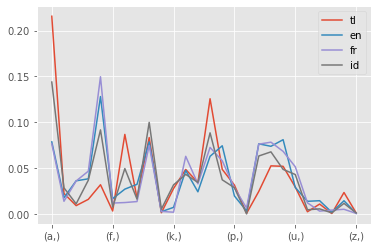

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import json

# 알파벳 출현 빈도 데이터 읽어 들이기
with open("./lang/freq.json", "r", encoding="utf-8") as fp:
    freq = json.load(fp)

# 언어마다 계산하기
lang_dic = {}
for i, label in enumerate(freq[0]["labels"]):
    fq = freq[0]["freqs"][i]
    if not (label in lang_dic):
        lang_dic[label] = fq
        continue # Q) 왜???
    for index, v in enumerate(fq):
        lang_dic[label][index] = (lang_dic[label][index] + v) / 2 # Q) 굳이 왜???

# Pandas의 DataFrame에 데이터 넣기
asclist = [[chr(n) for n in range(97, 97+26)]]
df = pd.DataFrame(lang_dic, index=asclist)

# 그래프 그리기
plt.style.use('ggplot')
# df.plot(kind="bar", subplots=True, ylim=(0, 0.15))
# plt.savefig("lang-plot.png")

df.plot(kind="line")
plt.show()

## 웹 인터페이스 추가하기

### 학습한 매개변수를 저장하는 프로그램
인터페이스를 추가한 후 여러 번 언어를 판별하는 프로그램을 만들 때 프로그램을 실행할 때마다 새로 데이터를 학습시키는 것은 쓸데없는,,,<br>
=> 학습시킨 매개변수를 저장하고 활용하자!!!

In [15]:
from sklearn import svm
import joblib # 책에선 from sklearn.externals import joblib => import joblib 만으로!!
import json

# 각 언어의 출현 빈도 데이터(JSON) 읽어 들이기
with open("./lang/freq.json", "r", encoding="utf-8") as fp:
    d = json.load(fp)
    data = d[0] # train 데이터들만!!
    
# 데이터 학습하기
clf = svm.SVC()
clf.fit(data["freqs"], data["labels"])

# 학습 데이터 저장하기
joblib.dump(clf, "./lang/freq.pkl")
print("Ok!!")

Ok!!


### Pickle 이란?? (pkl 형식이 뭐지?)
pickle 은 텍스트 상태의 데이터가 아닌 파이썬 객체 자체를 바이너리 파일로 저장하는 것<br>
즉, 텍스트 형태로 파일을 저장하는 것이 아니라 dictionary, list, tuple 과 같은 형태로 필요한 부분을 저장하는 것 <br>
문자열이 아닌 객체를 파일에 쓸 수 없기 때문에 pickle 모듈을 활용해 그 객체 자체를 바이너리로 저장하는 것

### joblib.dump & joblib.load
* dump(): 임의의 객체를 pkl 형식으로 저장한다.
* load(): pkl 형식으로 저장된 객체를 불러온다.

```python
import joblib
joblib.dump(<객체>, '<파일이름(obj.pkl)>')
obj = joblib.load('<파일이름(obj.pkl)>')
```

### 웹에서 사용할 수 있는 언어 판별 애플리케이션

In [1]:
import cgi, os.path, joblib

# 학습 데이터 읽어 들이기
# pklfile = os.path.dirname(__file__) # __file__ : 현재 수행중인 코드를 담고 있는 파일이 위치한 Path
pklfile = os.path.abspath('') + "/lang/freq.pkl" # jupyternote book 에선 현재 
clf = joblib.load(pklfile)

# 텍스트 입력 양식 출력하기
def show_form(text, msg=""):
    print("Content-Type: text/html; charset=utf-8")
    print("")
    print("""
        <html><body><form>
        <textarea name="text" rows="8" cols="40">{0}</textarea>
        <p><input type="submit" value="판정"></p>
        <p>{1}</p>
        </form></body></html>
    """.format(cgi.escape(text), msg)) 
    # cgi.excape: HTML 태그 및 문자 엔터티를 이스케이프하는 제한된 의미에서 HTML을 이스케이프하는 것이 좋다.

# 판정하기
def detect_lang(text):
    # 알파벳 출현 빈도 구하기
    text = text.lower()
    code_a, code_z = (ord("a"), ord("z"))
    cnt = [0 for i in range(26)]
    for ch in text:
        n = ord(ch) - code_a
        if 0 <= n <= 26: cnt[n] += 1
    total = sum(cnt)
    if total == 0: return "문자가 없습니다."
    freq = list(map(lambda n: n / total, cnt))
    # 언어 예측하기
    res = clf.predict([freq]) # Q) 굳이 왜 [] 안에 freq 를 넣었지?
    # 언어 코드를 한국어로 변환하기
    lang_dic = {"en": "영어", "fr": "프랑스어", "id": "인도네시아어", "tl": "타갈로그어"}
    return lang_dic[res[0]]

# 입력 양식의 값 읽어 들이기
form = cgi.FieldStorage() # cgi.FieldStorage() :  
text = form.getvalue("text", default="")
msg = ""
if text != "":
    lang = detect_lang(text)
    msg = "판정 결과: " + lang

# 입력 양식 출력
show_form(text, msg)


Content-Type: text/html; charset=utf-8



AttributeError: module 'cgi' has no attribute 'escape'